# Large scale text analysis with deep learning (3 points)

In this assignment, you will develop a deep learning model to predict salaries based on resumes (credits to to [Oleg Vasilev](https://github.com/Omrigan/)). While we will begin this project during our seminar class, it will require additional effort on your part to finalize and submit it as homework.

Following this, there is a supplementary task in another notebook titled homework_part2.ipynb. In this task, you are expected to conduct a more extensive study. This will involve testing various architectures to optimize prediction accuracy.

To secure full marks for this assignment, ensure a consistent training process with an MSE loss falling below 0.10. If necessary, feel free to experiment with different parameters and model architectures. If you achieve the desired results in the homework_part2.ipynb, you can either replicate your solution here or reference it explicitly in the comments when you submit.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from 
1) Yandex-disk [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7), or
2) the Kaggle ompetition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [3]:
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [4]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

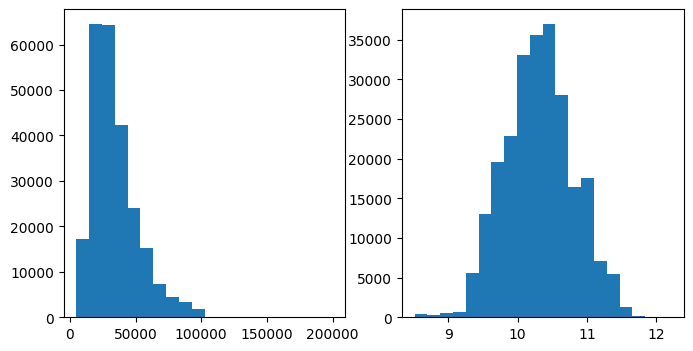

In [5]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [8]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
188579,71693228,MERCHANDISER,Key Responsibilities PlanningTo ensure a balan...,London South East,South East London,NaN,permanent,Elite Associates,Retail Jobs,50000 - 60000 per annum,55000,retailchoice.com,10.915107
40054,68359212,MidWeight Web DeveloperPermLondonAgency,A top London agency is looking for a very tale...,West London London South East,East Sheen,NaN,permanent,Gemini Search,IT Jobs,"From 30,000 to 40,000 per annum",35000,cwjobs.co.uk,10.463132
24412,67650641,Senior Support ETL Developer,"My client, a highly prestigious and well known...","City of London, London",The City,NaN,permanent,Capita Resourcing,IT Jobs,50000 - 60000/annum,55000,cv-library.co.uk,10.915107


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [9]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [15]:
import nltk
#TODO YOUR CODE HERE
to_lowercase = lambda text: str(text).lower()
data['Title'] = data['Title'].apply(to_lowercase)
data['FullDescription'] = data['FullDescription'].apply(to_lowercase)

tokenizer = nltk.tokenize.WordPunctTokenizer()
# YOUR CODE HERE
tokenize_text_and_split_on_space = lambda text: " ".join(tokenizer.tokenize(text))
data['Title'] = data['Title'].apply(tokenize_text_and_split_on_space)
data['FullDescription'] = data['FullDescription'].apply(tokenize_text_and_split_on_space)

Now we can assume that our text is a space-separated list of tokens:

In [16]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [33]:
from collections import Counter
token_counts = Counter(token for _,row in data[['Title', 'FullDescription']].iterrows() for text in row for token in text.split())

# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>
token_counts


Counter({'and': 2657388,
         '.': 2523216,
         ',': 2318606,
         'the': 2080994,
         'to': 2019884,
         'a': 1521925,
         'of': 1426213,
         'in': 1035792,
         'for': 867233,
         'with': 728884,
         'you': 694177,
         '****': 681869,
         'will': 652403,
         'be': 625163,
         'is': 599665,
         '/': 554003,
         'this': 497002,
         'as': 472859,
         'an': 442713,
         'experience': 429019,
         'are': 428534,
         ':': 415648,
         'on': 394777,
         'have': 361514,
         'or': 329512,
         'role': 292680,
         'work': 280280,
         'business': 275975,
         'your': 275371,
         'team': 271843,
         'we': 238825,
         'skills': 236248,
         'manager': 235225,
         '(': 234419,
         'sales': 229086,
         'our': 223441,
         'working': 222783,
         'within': 217418,
         'all': 216046,
         'that': 200655,
         'client

In [20]:
a = ['aa', 'bnbn', 'aa']
Counter(a)

Counter({'aa': 2, 'bnbn': 1})

In [34]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


dict_values([68563, 77071, 34427, 260, 8237, 93465, 681869, 77920, 223441, 198691, 599665, 7667, 1035792, 2318606, 2657388, 428534, 155766, 867233, 11180, 41160, 74918, 168938, 4554, 1033, 6534, 26638, 34076, 35689, 2801, 8, 1, 1855, 94623, 3333, 2019884, 238825, 17471, 54542, 10676, 18116, 94014, 29370, 271843, 171875, 1521925, 18978, 1426213, 32207, 2523216, 2080994, 21092, 47835, 1886, 95158, 4170, 3828, 728884, 57234, 75153, 28510, 429019, 41459, 200655, 79276, 10290, 694177, 131569, 33350, 275371, 91480, 236248, 78218, 81264, 6399, 6295, 69344, 696, 52768, 64, 17, 17440, 7820, 90594, 74275, 74416, 10996, 1283, 27708, 58703, 161650, 6042, 8397, 290, 38110, 1578, 40058, 329512, 280280, 81835, 14200, 6243, 163958, 71837, 652403, 58950, 361514, 32728, 9854, 3689, 234419, 36699, 472859, 156, 28561, 15059, 7924, 185958, 92623, 45878, 53699, 89962, 20080, 37688, 26735, 20143, 66314, 66618, 42968, 31599, 415648, 554003, 552, 59732, 274, 115, 436, 2223, 212, 576, 412, 8189, 1149, 88122, 62

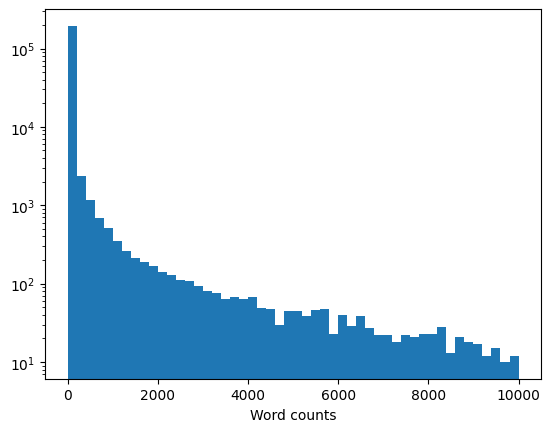

In [35]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [41]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [42]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [43]:
token_to_id = {token: index for index, token in enumerate(tokens)}

In [44]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [45]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [47]:
data["Title"][::100000]

0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object

In [46]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[    2     3     4     1     1]
 [  550  2380     1     1     1]
 [  320 10714   392   307    32]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [48]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [52]:
categorical_vectorizer.vocabulary_

{'Category=Accounting & Finance Jobs': 0,
 'Category=Admin Jobs': 1,
 'Category=Charity & Voluntary Jobs': 2,
 'Category=Consultancy Jobs': 3,
 'Category=Creative & Design Jobs': 4,
 'Category=Customer Services Jobs': 5,
 'Category=Domestic help & Cleaning Jobs': 6,
 'Category=Energy, Oil & Gas Jobs': 7,
 'Category=Engineering Jobs': 8,
 'Category=Graduate Jobs': 9,
 'Category=HR & Recruitment Jobs': 10,
 'Category=Healthcare & Nursing Jobs': 11,
 'Category=Hospitality & Catering Jobs': 12,
 'Category=IT Jobs': 13,
 'Category=Legal Jobs': 14,
 'Category=Logistics & Warehouse Jobs': 15,
 'Category=Maintenance Jobs': 16,
 'Category=Manufacturing Jobs': 17,
 'Category=Other/General Jobs': 18,
 'Category=PR, Advertising & Marketing Jobs': 19,
 'Category=Part time Jobs': 20,
 'Category=Property Jobs': 21,
 'Category=Retail Jobs': 22,
 'Category=Sales Jobs': 23,
 'Category=Scientific & QA Jobs': 24,
 'Category=Social work Jobs': 25,
 'Category=Teaching Jobs': 26,
 'Category=Trade & Construct

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [49]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [54]:
test_batch = make_batch(data_train[:3], max_len=10)

In [68]:
print(tokens[test_batch['Title'][0][2].item()])
data_train[:3]

worker


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,69173058,senior support worker,senior support worker wanted a senior support ...,"Taunton, Somerset Somerset South West",Taunton,NaN,permanent,Other,Healthcare & Nursing Jobs,15931 - 17082 per annum,16506,totaljobs.com,9.711540
1,72450873,statistical / mathematical modeller in pharmac...,statistical / mathematical modeller in pharmac...,North West,North West London,NaN,permanent,Other,Scientific & QA Jobs,"From 30,000 to 40,000 per annum 30-40K",35000,totaljobs.com,10.463132
2,68364211,emc team leader ( def stan ),the opportunity my client is currently seeking...,Surrey,Surrey,NaN,permanent,Other,Engineering Jobs,45k + Bonus + Pension,45000,justengineers.net,10.714440


In [51]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[  320,    89,  1657,     1,     1,     1,     1],
         [ 5130,   130,    25,   173,    14,   562, 21820],
         [ 2246,    42,  1433,   109,  9312,  9313,   116]]),
 'FullDescription': tensor([[  320,    89,  1657,  2890,    44,   320,    89,  1657,    12,  2890],
         [ 5130,   130,    25,   173,    14,   562, 21820,  1334,   129,     8],
         [   49,    66,   444,    11,    12,    37,   576,    44,    42,  1433]]),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144])}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

In [53]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

In [69]:
embeddings.get_vector(tokens[test_batch['Title'][0][2].item()])

array([ 0.0019728 , -0.03171   ,  0.022173  ,  0.0093806 , -0.064047  ,
       -0.036148  ,  0.056454  , -0.12101   ,  0.14969   , -0.027018  ,
       -0.050521  ,  0.052807  , -0.025352  , -0.015753  , -0.10326   ,
        0.03395   ,  0.079296  ,  0.11414   ,  0.028178  ,  0.068425  ,
       -0.042254  ,  0.096741  , -0.05344   ,  0.065884  , -0.036835  ,
       -0.0094718 ,  0.017887  ,  0.041807  , -0.031999  , -0.053036  ,
        0.0073101 , -0.017093  ,  0.015755  ,  0.0093322 , -0.0042914 ,
        0.050031  ,  0.048638  ,  0.024015  ,  0.0072169 , -0.017318  ,
        0.038571  , -0.17085   , -0.0029728 ,  0.020381  ,  0.01373   ,
        0.04285   ,  0.0020136 , -0.017899  , -0.036984  ,  0.067862  ,
       -0.0058826 ,  0.088233  ,  0.023149  ,  0.00043401,  0.0047057 ,
       -0.014745  ,  0.043522  , -0.03276   , -0.078696  , -0.081058  ,
       -0.089595  , -0.015821  ,  0.14672   ,  0.0052096 ,  0.084474  ,
        0.056467  ,  0.040328  , -0.099176  ,  0.053011  , -0.04

In [110]:
def token_to_embedding(token):
    if token in embeddings.key_to_index:
        index_of_token = embeddings.get_index(token)
        return embeddings.get_vector(index_of_token)
    else:
        return torch.tensor(nn.Embedding(1, 300).weight).numpy().flatten()


embeddings_of_tokens_matrix = np.array([token_to_embedding(token) for token in tokens], dtype=np.float32)


/tmp/ipykernel_31062/2858900902.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(nn.Embedding(1, 300).weight).numpy().flatten()


In [112]:
emb = nn.Embedding(len(tokens), 300)
emb.weight.data.copy_(torch.tensor(embeddings_of_tokens_matrix)).shape

torch.Size([34158, 300])

In [120]:
b = make_batch(data_train[:3], max_len=10)
b['Categorical']

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
emb_dim = 300

class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, emb_dim)
        self.emb.weight.data.copy_(torch.tensor(embeddings_of_tokens_matrix))
        self.title_seq = nn.Sequential(
            nn.Conv1d(emb_dim, hid_size, kernel_size=3, padding=1),
            nn.ReLU()
            )
        self.full_desc_seq = nn.Sequential(
            nn.Conv1d(emb_dim, hid_size, kernel_size=3, padding=1),
            nn.ReLU()
            )
        self.cat_linear =  nn.Sequential(
            nn.Linear(n_cat_features, hid_size),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(hid_size * 3, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1) 
        )
        
    def forward(self, batch):
        title_embs = self.emb(batch['Title']).transpose(2,1)
        full_desc_embs = self.emb(batch['FullDescription']).transpose(2,1)
        cat_features = self.cat_linear(batch['Categorical'])

        title_features = F.max_pool1d(self.title_seq(title_embs), kernel_size=title_embs.size(2)).squeeze(2)
        full_desc_features = F.max_pool1d(self.full_desc_seq(full_desc_embs), kernel_size=full_desc_embs.size(2)).squeeze(2)

        combined_features = torch.cat([title_features, full_desc_features, cat_features], axis=1)

        output = self.fc(combined_features)

        return output.squeeze(1)
        
        
        

In [138]:
model = SalaryPredictor()

In [139]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100]), f'real_shape = {dummy_pred.shape}'
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [140]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [141]:
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 5

/home/nikolay/Документы/Projects/ML_Projects/main_ml_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [142]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [ ]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val, device=device)

      

### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [ ]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 

    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [ ]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [ ]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

In [ ]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

In [ ]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)